# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


In [3]:
# !pip install fluidsynth
# !pip install --upgrade pyfluidsynth
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [189]:
# set datapath, data source: https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
data_dir = pathlib.Path('data/maestro-v2.0.0')
midi_files = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(midi_files))

Number of files: 1282


## Preprocess (Extracting Note from midi files)

midi file is different format from typical audio(mp3,wav) it a record of pitch/velocity/duration of the note instead of actual sound recording

 prepare midi_to_note function, this is to extract midi file into note
which is contain 
- pitch - the key of the note range from 0-127 starting from C-1 (C in lowest octave)
from the example file
    - 55 is G3
    - 81 is A#5 (A sharp)
    - 62 is D4 etc
- start,end - when do note start and end in the sequence which use to calculate duration
- step - different between start of itself and start of the note before them (this is for knowning space between each note)


In [192]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append((end - start) * random.randint(2,4))
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

sample_file = 'example.midi'
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,0.000000,0.079545,0.000000,0.238636
1,31,0.009091,0.075000,0.009091,0.263636
2,44,0.111364,0.184091,0.102273,0.145455
3,32,0.113636,0.186364,0.002273,0.218182
4,46,0.175000,0.270455,0.061364,0.286364


## Visualize note sequence

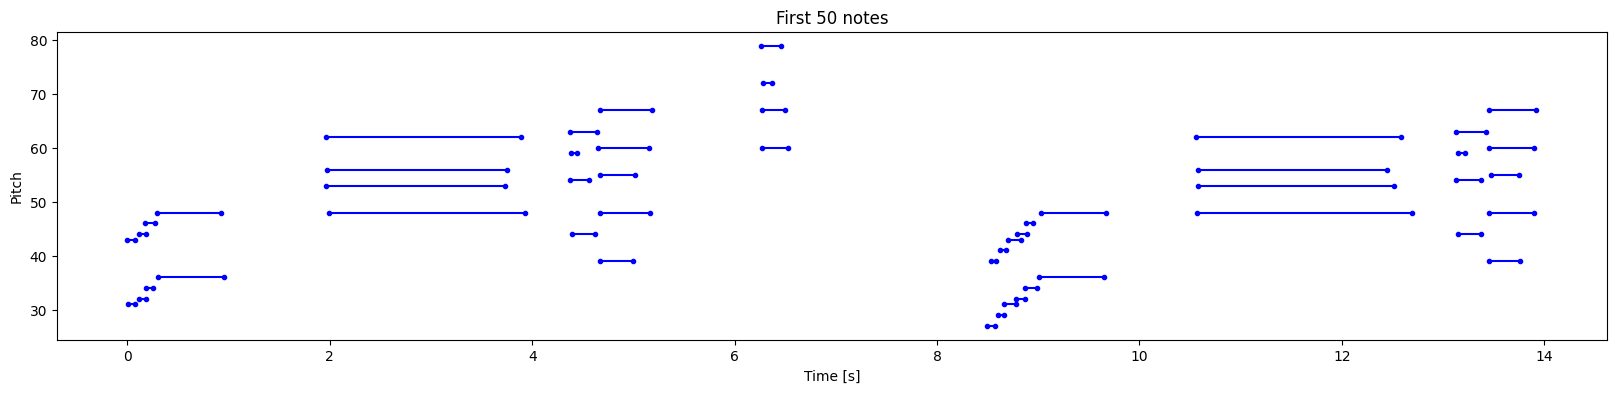

In [193]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

sample_file = 'example.midi'
raw_notes = midi_to_notes(sample_file)
#first 50 note
plot_piano_roll(raw_notes, count=50)   
#whole track
# plot_piano_roll(raw_notes)    

## Function for playing Midi file
midi file is different format from typical audio(mp3,wav) it a record of pitch/velocity/duration of the note instead of actual sound recording

In [133]:
import pygame
import time

def play_midi(file_path):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    
    # Wait a bit to ensure playback has started
    time.sleep(2)
    
    print("Press 'q' to quit")
    while pygame.mixer.music.get_busy():
        # Check for keyboard input to stop playback
        if input("Press 'q' to quit: ").lower() == 'q':
            pygame.mixer.music.stop()
            break

example_file = 'example.midi'
play_midi(example_file)

Press 'q' to quit


Press 'q' to quit:  q


# Create training dataset

- randomly select midi file from "midi_files"(data from 1st step) and extract note dataframe and concat them together
- then format them into 2D array by key order
- ```
  array([[pitch1 , step1,  duration1 ],
         [pitch2 , step2,  duration2 ],
         [pitch3 , step3,  duration3 ]]...)

- and convert to pytorch tensor
- seq_length is to set how many note to feed to model at a time, (collate_fn is for combining samples into batch)

In [215]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random

num_files = 5
all_notes = []
selected_files = random.sample(midi_files, num_files)
for f in selected_files:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)


n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key].values for key in key_order], axis=1)

# Convert to PyTorch tensors
train_notes = torch.tensor(train_notes, dtype=torch.float32)

class NotesDataset(Dataset):
    def __init__(self, notes, seq_length):
        self.notes = notes
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.notes) - self.seq_length
    
    def __getitem__(self, idx):
        idx = idx.item() if torch.is_tensor(idx) else idx
        return {
            'sequence': self.notes[idx:idx+self.seq_length],
            'target': self.notes[idx+self.seq_length]
        }

def collate_fn(batch):
    sequences = [item['sequence'] for item in batch]
    targets = [item['target'] for item in batch]
    return {
        'sequences': torch.stack(sequences),
        'targets': torch.stack(targets)
    }

seq_length = 50
notes_ds = NotesDataset(train_notes, seq_length)
train_loader = DataLoader(notes_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Example usage
for batch in train_loader:
    seq_batch, target_batch = batch['sequences'], batch['targets']
    print('Sequence batch shape:', seq_batch.shape)
    print('Target batch shape:', target_batch.shape)
    break  # Stop after the first batch for demonstration


Number of notes parsed: 21101
Sequence batch shape: torch.Size([64, 50, 3])
Target batch shape: torch.Size([64, 3])


## Check Training Data Charateristic
```
this was added later during fine tuning the model to generate accepatable output sound
use to check distributionfor each value (pitch, step, duration)
in data loader, I use "notes['duration'].append((end - start) * random.randint(2,4))", randomly multiplying duration by 2-4
without it, with majority of data having low step and low duration (medley of note) the early model/attempt are very unpleasant

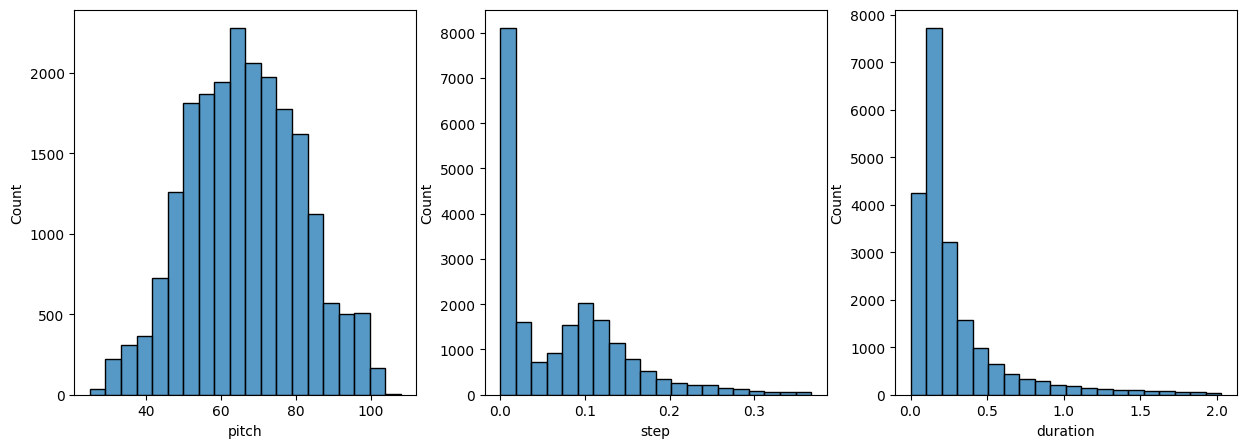

In [216]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(all_notes)

# Model
```
LSTM-based model follow by 3 linears layer to predict note's value (pitch,step,duration)
using custom lost function, this is for step and duration that can't be negative (negative step/duration would cause error to midi file that end's of the note is before the start of the note)
and using mean squared error to keep the prediction (note generate) stay relatively the same with training data (ie maintain the pattern that would be common in music and hence model could generate something good)
while pitch still use CrossEntropyLoss because it a classification (note from 0 to 127)

In [217]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define custom loss function for step and duration
def mse_with_positive_pressure(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    positive_pressure = 10 * torch.clamp(-y_pred, min=0.0)
    return mse + positive_pressure

input_size = 3
hidden_size = 128
learning_rate = 0.005

# Define the model architecture
class MusicModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MusicModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.pitch = nn.Linear(hidden_size, 128)
        self.step = nn.Linear(hidden_size, 1)
        self.duration = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pitch_out = self.pitch(lstm_out[:, -1, :])
        step_out = self.step(lstm_out[:, -1, :])
        duration_out = self.duration(lstm_out[:, -1, :])
        return {
            'pitch': pitch_out,
            'step': step_out,
            'duration': duration_out
        }

model = MusicModel(input_size, hidden_size).cuda()  # Move model to GPU

#check that model on gpu
for param in model.parameters():
    print(param.device)
    break

cuda:0


# Training model
```
because this scenario doesn't have an actual ground truth that the note generated is good or not (it subjective that music is good or bad)
but Step MSE do show that most predicted step (gap between note) is really close to trained data
for Duration MSE that note predicted have some variant base on both modification for duration during data loader to avoid repetitive/undesire output
while Pitch Accuracy is extremely low due scenario
(for more format data like stock/market prices, it would be able to comparing it with ground truth directly)

and for epoch_loss that sum up from each lose function (*0.05 adjustment for pitch's CrossEntropy) and average with number of batches

Epoch [1/50], Loss: 0.6036, Pitch Accuracy: 0.0500, Step MAE: 0.0793, Duration MAE: 0.2631
Epoch [2/50], Loss: 0.6066, Pitch Accuracy: 0.0550, Step MAE: 0.0793, Duration MAE: 0.2618
Epoch [3/50], Loss: 0.6061, Pitch Accuracy: 0.0500, Step MAE: 0.0799, Duration MAE: 0.2601
Epoch [4/50], Loss: 0.6421, Pitch Accuracy: 0.0489, Step MAE: 0.0826, Duration MAE: 0.2773
Epoch [5/50], Loss: 0.6399, Pitch Accuracy: 0.0358, Step MAE: 0.0811, Duration MAE: 0.2777
Epoch [6/50], Loss: 0.6518, Pitch Accuracy: 0.0446, Step MAE: 0.0814, Duration MAE: 0.2709
Epoch [7/50], Loss: 0.6144, Pitch Accuracy: 0.0500, Step MAE: 0.0797, Duration MAE: 0.2619
Epoch [8/50], Loss: 0.6422, Pitch Accuracy: 0.0514, Step MAE: 0.0823, Duration MAE: 0.2701
Epoch [9/50], Loss: 0.6318, Pitch Accuracy: 0.0476, Step MAE: 0.0801, Duration MAE: 0.2694
Epoch [10/50], Loss: 0.6250, Pitch Accuracy: 0.0496, Step MAE: 0.0815, Duration MAE: 0.2604
Epoch [11/50], Loss: 0.6124, Pitch Accuracy: 0.0514, Step MAE: 0.0800, Duration MAE: 0.26

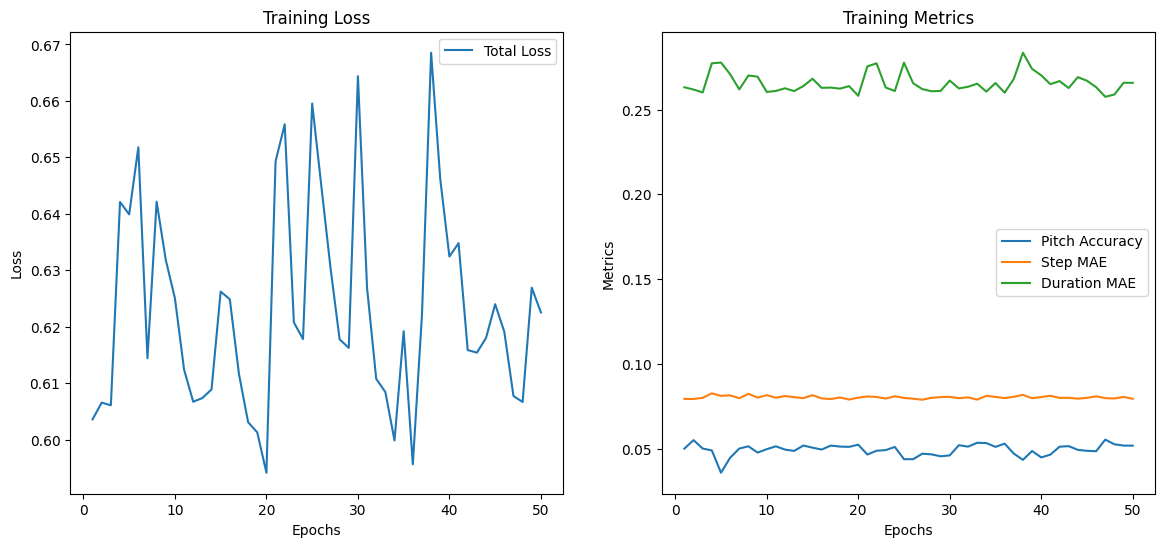

In [232]:
# Import MAE loss function
from torch.nn.functional import l1_loss
#Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = {
    'pitch': nn.CrossEntropyLoss(),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure
}
# Initialize history dictionary
history = {'loss': [], 'pitch_accuracy': [], 'step_mae': [], 'duration_mae': [], 'grad_norm': []}

# Training loop with pitch accuracy and MAE for step and duration
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    correct_pitches = 0
    total_pitches = 0
    total_step_mae = 0.0
    total_duration_mae = 0.0
    total_grad_norm = 0.0
    
    for batch in train_loader:
        sequences, targets = batch['sequences'].cuda(), batch['targets'].cuda()
        
        optimizer.zero_grad()
        outputs = model(sequences)
        
        pitch_predictions = outputs['pitch'].argmax(dim=1)
        correct_pitches += (pitch_predictions == targets[:, 0].long()).sum().item()
        total_pitches += targets.size(0)
        
        step_mae = l1_loss(outputs['step'].squeeze(), targets[:, 1], reduction='sum').item()
        duration_mae = l1_loss(outputs['duration'].squeeze(), targets[:, 2], reduction='sum').item()
        
        total_step_mae += step_mae
        total_duration_mae += duration_mae
        
        losses = {
            'pitch': loss_fn['pitch'](outputs['pitch'], targets[:, 0].long()),
            'step': loss_fn['step'](outputs['step'].squeeze(), targets[:, 1]),
            'duration': loss_fn['duration'](outputs['duration'].squeeze(), targets[:, 2])
        }
        
        total_loss = 0.05 * losses['pitch'] + losses['step'] + losses['duration']
        total_loss = torch.mean(total_loss)  # Calculate mean over the batch
        
        # Backward pass and gradient calculation
        total_loss.backward()
        optimizer.step()
        
        # Track gradient norms
        total_grad_norm += calculate_gradient_norm(model)
        
        epoch_loss += total_loss.item()
    
    epoch_loss /= len(train_loader)
    pitch_accuracy = correct_pitches / total_pitches
    step_mae_avg = total_step_mae / total_pitches
    duration_mae_avg = total_duration_mae / total_pitches
    
    history['loss'].append(epoch_loss)
    history['pitch_accuracy'].append(pitch_accuracy)
    history['step_mae'].append(step_mae_avg)
    history['duration_mae'].append(duration_mae_avg)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Pitch Accuracy: {pitch_accuracy:.4f}, Step MAE: {step_mae_avg:.4f}, Duration MAE: {duration_mae_avg:.4f}')

# Plotting the training loss and metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history['loss'], label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history['pitch_accuracy'], label='Pitch Accuracy')
plt.plot(range(1, epochs+1), history['step_mae'], label='Step MAE')
plt.plot(range(1, epochs+1), history['duration_mae'], label='Duration MAE')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Metrics')
plt.legend()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

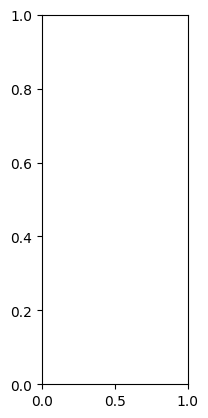

In [234]:
def calculate_gradient_norm(model):
    total_norm = 0.0
    count = 0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            count += 1
    total_norm = (total_norm / count) ** (1. / 2) if count > 0 else 0.0
    return total_norm

plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), history['grad_norm'], label='Gradient Norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm')
plt.legend()

## Prediction Function
```
this predict the next note from input data, using temperature to control randoness of the output to return 3 values the same way midi file needed (pitch,step,duration)
it will use initial input pattern to predict next note
temperature > 1.0, the model would return more random data due to it allowing range for softmax function
while temperature < 1.0, will restrict the output to be relatively similar to training data set pattern

In [ ]:
import torch
import numpy as np
import pandas as pd

def predict_next_note(
    notes: np.ndarray, 
    model: torch.nn.Module, 
    temperature: float = 1.0) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""
    
    assert temperature > 0
    
    # Convert input to PyTorch tensor and add batch dimension
    inputs = torch.tensor(notes, dtype=torch.float32).unsqueeze(0).cuda()
    
    with torch.no_grad():
        predictions = model(inputs)
    
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']
    
    # Apply temperature for sampling
    pitch_logits /= temperature
    
    # Sample pitch using categorical distribution
    pitch_probs = torch.softmax(pitch_logits, dim=-1)
    pitch_idx = torch.multinomial(pitch_probs, num_samples=1).squeeze().item()
    
    # Sample step and duration
    step = torch.clamp(step, min=0.0).squeeze().item()
    duration = torch.clamp(duration, min=0.0).squeeze().item()
    
    return pitch_idx, step, duration

## Usage
```
this using the training data "all_notes" that created earlier, and randomly pick start index and pick the same amount 'seq_length' that used to feed the model early

In [214]:
vocab_size = 128

sample_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

print(generated_notes_df)

     pitch  step  duration  start  end
0       60   0.0       0.0    0.0  0.0
1       75   0.0       0.0    0.0  0.0
2       11   0.0       0.0    0.0  0.0
3       93   0.0       0.0    0.0  0.0
4       62   0.0       0.0    0.0  0.0
..     ...   ...       ...    ...  ...
295    124   0.0       0.0    0.0  0.0
296    116   0.0       0.0    0.0  0.0
297     38   0.0       0.0    0.0  0.0
298     47   0.0       0.0    0.0  0.0
299     46   0.0       0.0    0.0  0.0

[300 rows x 5 columns]


     pitch      step  duration      start        end
0       79  0.024478  0.293328   0.024478   0.317805
1       79  0.024866  0.320611   0.049343   0.369954
2       31  0.025403  0.332438   0.074747   0.407185
3       44  0.031908  0.264589   0.106655   0.371244
4       84  0.042239  0.309993   0.148894   0.458887
..     ...       ...       ...        ...        ...
295     72  0.252287  2.633616  58.430382  61.063998
296     43  0.247438  2.604010  58.677820  61.281829
297     26  0.255977  2.642617  58.933797  61.576414
298     41  0.549996  0.629475  59.483793  60.113268
299     70  0.241198  0.990898  59.724990  60.715888

[300 rows x 5 columns]


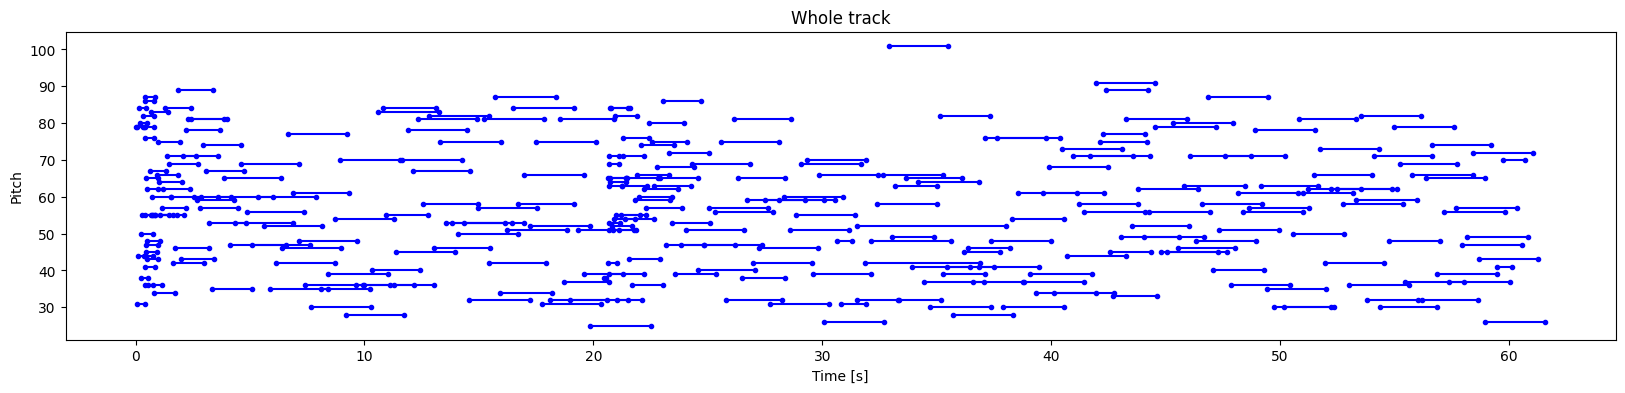

In [235]:
vocab_size = 128
temperature = 3.0
num_predictions = 300

key_order = ['pitch', 'step', 'duration']  

generated_notes = []
prev_start = 0

# Generating new notes
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

# Creating a DataFrame for generated notes
generated_notes_df = pd.DataFrame(
    generated_notes, columns=[*key_order, 'start', 'end'])

print(generated_notes_df)
plot_piano_roll(generated_notes_df)

## now convert Dataframe back to Midi format and play

In [165]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 70,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [236]:
instrument_name = 'Acoustic Grand Piano'

out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes_df, out_file=out_file, instrument_name=instrument_name)

play_midi(out_file)

Press 'q' to quit


Press 'q' to quit:  q


     pitch      step  duration       start         end
0       79  0.024478  0.293328    0.024478    0.317805
1       79  0.024866  0.320611    0.049343    0.369954
2       31  0.025403  0.332438    0.074747    0.407185
3       44  0.031908  0.264589    0.106655    0.371244
4       84  0.042239  0.309993    0.148894    0.458887
..     ...       ...       ...         ...         ...
595     32  0.226270  2.484144  163.561341  166.045485
596     54  0.314815  2.515694  163.876156  166.391850
597     62  0.235111  2.551224  164.111267  166.662491
598     74  0.235566  2.556982  164.346833  166.903816
599     37  0.225500  2.487587  164.572333  167.059920

[600 rows x 5 columns]


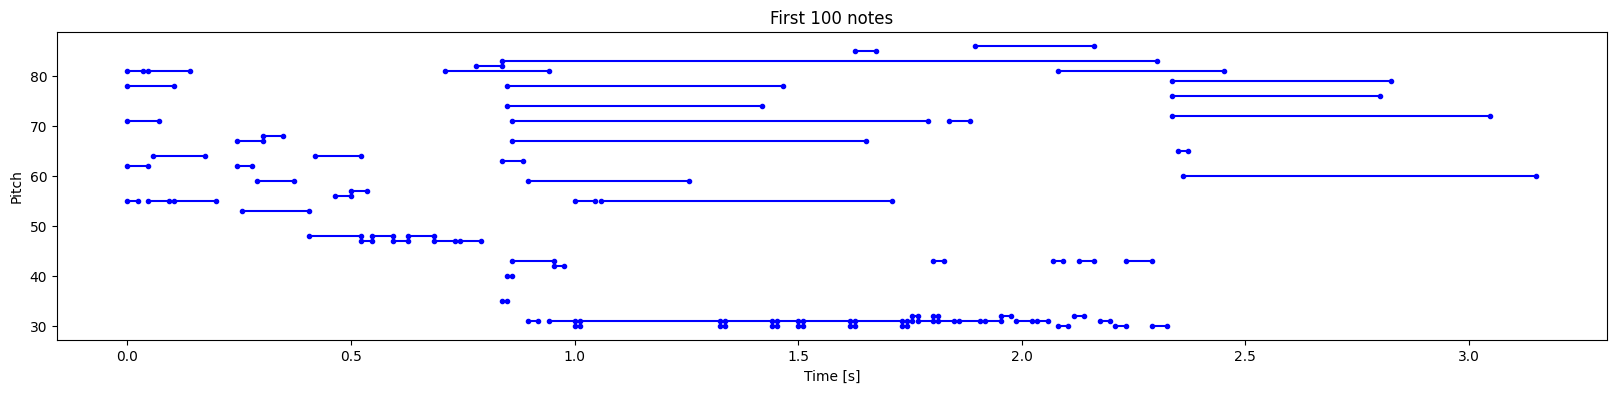

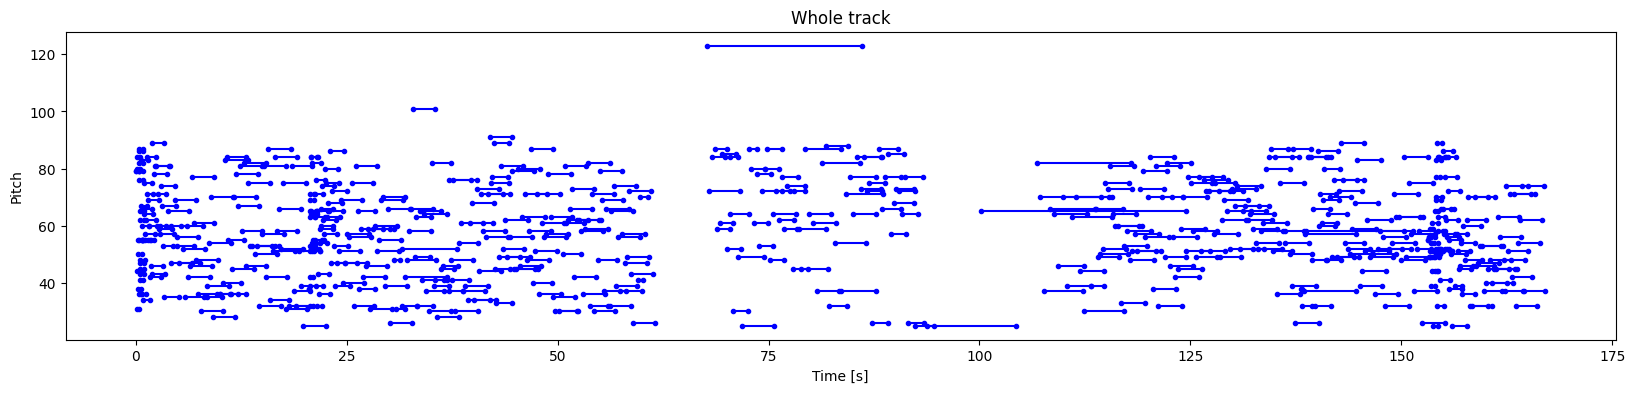

In [237]:
midi_file = 'a-jazz-piano-11041.midi'
raw_notes = midi_to_notes(midi_file)

seq_length = 80 

sample_notes = raw_notes.iloc[:seq_length]

plot_piano_roll(sample_notes, count=100)

# Extract pitch, step, and duration columns
key_order = ['pitch', 'step', 'duration']
input_notes = np.stack([sample_notes[key].values for key in key_order], axis=1)

# Normalize pitch (if needed) similar to training sequences
vocab_size = 128  # Assuming 128 possible pitches
input_notes[:, 0] /= vocab_size

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

# Creating a DataFrame for generated notes
generated_notes_df = pd.DataFrame(
    generated_notes, columns=[*key_order, 'start', 'end'])

print(generated_notes_df)

plot_piano_roll(generated_notes_df)

In [238]:
instrument_name = 'Acoustic Grand Piano'

out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes_df, out_file=out_file, instrument_name=instrument_name)

play_midi(out_file)

Press 'q' to quit


Press 'q' to quit:  q


---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?
5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.
6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?
8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.


1. ```
   RNN is neural network that designed to work with data sequence and predict the outcome from them instead of consider only the input
   when feedforward process each training/prediction give output then for next prediction, previous data doesn't affect the outcome
   while RNN's hidden state store data(pattern/information of the sequence) and its recurrent connection to form relationship between output
   - RNN also able to process and output various length of data sequence, unlike fixed-size input-output in feedforward model
   

2. ```
   recurrent connection is to enable the model to store value from previous inputs (in hidden state). which serve as context from earlier data of the sequence to predicting/generating next data. (in this case knowing what previous note is, and learn pattern from data of which note could follow it)
   because of this it able to accept various lengths and adjust with each input, and learn pattern between them
3. ```
   to allow RNNs in capturing long-term dependencies.
   - Cell State: Linear flow of information that runs through the entire sequence, allowing LSTM to maintain long-term memory.
   - Forget Gate: Decides what information to throw away from the cell state.
   - Input Gate: update to the cell state.
   - Output Gate: Decides the output based on the cell state.
   ```
   and for vanishing/exploding gradient, it 
4. 
5. 
6. 
7. 
8. 
9. 
10. 
11.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.